$\textbf{Team Keep it Up}$ <br>
* Akbar Nugroho Rianto<br>
* Dzakiyyah Hanifatulqolbi<br>
* Hans Halwi<br>
* Ninatantya Budi<br>
* Yoga Arif Prasetyo<br>

# Introduction

**Problem**<br>
Terjadinya penurunan budget untuk campaign telemarketing sebesar 20% dengan ekspektasi conversion rate tidak kurang dari campaign sebelumnya. <br>
* Budget awal sebesar 116,718 → 93,374.48
* Conversion rate 11.7%

**Goal**<br>
Mempertahankan conversion rate sebesar 11.7% dengan budget yang tersedia

**Objective**<br>
Membuat model machine learning untuk membuat list/klasifikasi data customer potensial

**Business Metric**<br>
* Jumlah customer yang membuka tabungan deposito selama campaign
* Cost yang dikeluarkan untuk menarik customer (customer acquisition cost) 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import statsmodels.api as sm
from imblearn import under_sampling, over_sampling

# Load and Describe Data

## Load Data

In [2]:
df = pd.read_csv('train.csv',sep=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


## Data Description

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Numerical Data

In [4]:
num_dtypes = ['int16','int32','int64','float16','float32','float64']

num_df = df.select_dtypes(include=num_dtypes)
numericals = num_df.columns

print(numericals)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


## Non Numerical Data

In [5]:
cat_dtypes = ['object']

cat_df = df.select_dtypes(include=cat_dtypes)
categoricals = cat_df.columns

print(categoricals)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


In [6]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [7]:
df['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [8]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [9]:
df['default'].value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [10]:
df['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [11]:
df['loan'].value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [12]:
df['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [13]:
df['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

In [14]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [15]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

# Data Preparation

In [16]:
print('Total Row', df.shape[0], ' ,Total Feature', df.shape[1],'\n')

Total Row 45211  ,Total Feature 17 



## Missing Value

In [17]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,age,0
1,job,0
2,marital,0
3,education,0
4,default,0
5,balance,0
6,housing,0
7,loan,0
8,contact,0
9,day,0


**Tidak ada missing value**

## Duplicated Data

In [18]:
df.duplicated().value_counts()

False    45211
dtype: int64

In [19]:
df.duplicated(subset= ['age','job','marital','education','default','balance','housing','loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays','previous', 'poutcome']).any()

False

**Tidak ada data duplicate**

## Outlier

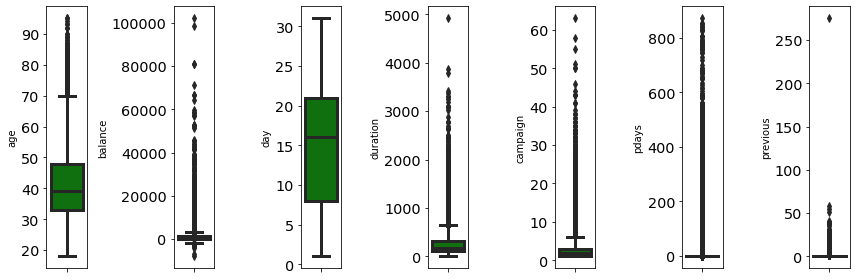

In [20]:
for i in range(0, len(numericals)):
    plt.subplot(1, len(numericals), i+1)
    sns.boxplot(y=df[numericals[i]], color='green', orient='v')
    plt.tight_layout()

**Dilihat dari Dataset ini, outlier akan dibiarkan saja karena data memang bervariasi**

## Feature Engineering

### Cost (from Duration)

In [21]:
df['cost'] = df['duration']*0.01

### Job

In [22]:
##Grouping Jenis Pekerjaan menjadi 7 kelompok
list_jobgroup = []

for i, x in df.iterrows():
    if x['job'] == 'management':
        jobgroup = 'employee'
    elif x['job'] == 'technician':
        jobgroup = 'employee'
    elif x['job'] == 'admin.':
        jobgroup = 'employee'
    elif x['job'] == 'services':
        jobgroup = 'employee'      
    elif x['job'] == 'blue-collar':
        jobgroup = 'manual labor'
    elif x['job'] == 'housemaid':
        jobgroup = 'manual labor'
    elif x['job'] == 'self-employed':
        jobgroup = 'self-employed'
    elif x['job'] == 'entrepreneur':
        jobgroup = 'self-employed'
    elif x['job'] == 'retired':
        jobgroup = 'retired'
    elif x['job'] == 'student':
        jobgroup = 'student'
    elif x['job'] == 'unemployed':
        jobgroup = 'unemployed'
    else:
        jobgroup = 'unknown'
    list_jobgroup.append(jobgroup)

df['job_group'] = list_jobgroup

### Balance

In [23]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

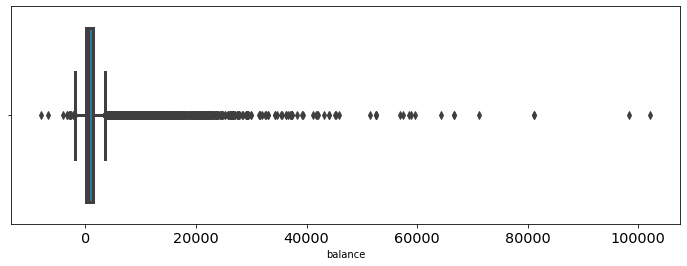

In [24]:
ax = sns.boxplot(x="balance", data=df)

In [25]:
list_balgroup = []

for i, x in df.iterrows():
    if x['balance'] <= 0 :
        balgroup = '<= 0'
    elif x['balance'] >=1 and x['balance'] <= 286 :
        balgroup = '1 - 286'    
    elif x['balance'] >=287 and x['balance'] <= 572 :
        balgroup = '287 - 572'    
    elif x['balance'] >=573 and x['balance'] <= 857 :
        balgroup = '573 - 857'    
    elif x['balance'] >=858 and x['balance'] <= 1142 :
        balgroup = '858 - 1142'        
    elif x['balance'] >=1143 and x['balance'] <= 1427 :
        balgroup = '1143 - 1427'   
    elif x['balance'] >= 1428   :
        balgroup = '>= 1428'
        
        
    else:
        balgroup = 'unknown'
    list_balgroup.append(balgroup)

df['balgroup'] = list_balgroup

Dilakukan feature engineering untuk menambahkan range untuk kolom balance dengan range sebagai berikut : <br>
<= 0<br>
1 - 286<br>
287 - 572<br>
573 - 857<br>858 - 1142<br>
1143 - 1427
<br>>= 1428<br>

In [26]:
list_agegroup = []

for i, x in df.iterrows():
    if x['age'] >= 18 and x['age'] <= 33:
        agegroup = '18 - 33'
    elif x['age'] >= 34 and x['age'] <= 49:
        agegroup = '34 - 49'
    elif x['age'] >= 50 and x['age'] <= 65:
        agegroup = '50 - 65'
    elif x['age'] >= 66 and x['age'] <= 81:
        agegroup = '66 - 81'      
    elif x['age'] >= 82 and x['age'] <= 97:
        agegroup = '82 - 97'

    list_agegroup.append(agegroup)

df['age_group'] = list_agegroup

In [27]:
data_visual = df.copy()
df_model = df.copy()

### Label Encoding

In [28]:
df_model['default'].replace('no', 0, inplace = True)
df_model['default'].replace('yes', 1, inplace = True)
df_model['housing'].replace('no', 0, inplace = True)
df_model['housing'].replace('yes', 1, inplace = True)
df_model['loan'].replace('no', 0, inplace = True)
df_model['loan'].replace('yes', 1, inplace = True)
df_model['y'].replace('no', 0, inplace = True)
df_model['y'].replace('yes', 1, inplace = True)

### Handling Unknown Data (Job & Education)

In [29]:
df_model['job_group'].replace(['unknown'],df_model['job_group'].mode(),inplace = True)
df_model['education'].replace(['unknown'],df_model['education'].mode(),inplace = True)

### OHE

In [30]:
cats_oh = ['job_group','marital','education','contact','poutcome']
for cat in cats_oh:
    onehots = pd.get_dummies(df_model[cat], prefix=cat)
    df_model = df_model.join(onehots)
    
df_model.sample(5,random_state=42)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3776,40,blue-collar,married,secondary,0,580,1,0,unknown,16,...,0,1,0,0,0,1,0,0,0,1
9928,47,services,single,secondary,0,3644,0,0,unknown,9,...,0,1,0,0,0,1,0,0,0,1
33409,25,student,single,tertiary,0,538,1,0,cellular,20,...,0,0,1,1,0,0,0,0,0,1
31885,42,management,married,tertiary,0,1773,0,0,cellular,9,...,0,0,1,1,0,0,1,0,0,0
15738,56,management,married,tertiary,0,217,0,1,cellular,21,...,0,0,1,1,0,0,0,0,0,1


### Remove Features

In [31]:
df_model.drop(cats_oh, axis=1, inplace=True)
df_model.sample(10,random_state=42)

,age,job,default,balance,housing,loan,day,month,duration,campaign,...,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3776,40,blue-collar,0,580,1,0,16,may,192,1,...,0,1,0,0,0,1,0,0,0,1
9928,47,services,0,3644,0,0,9,jun,83,2,...,0,1,0,0,0,1,0,0,0,1
33409,25,student,0,538,1,0,20,apr,226,1,...,0,0,1,1,0,0,0,0,0,1
31885,42,management,0,1773,0,0,9,apr,311,1,...,0,0,1,1,0,0,1,0,0,0
15738,56,management,0,217,0,1,21,jul,121,2,...,0,0,1,1,0,0,0,0,0,1
30813,28,blue-collar,0,1134,0,0,9,feb,130,3,...,0,1,0,1,0,0,0,0,0,1
35463,24,management,0,1085,0,1,7,may,95,6,...,0,0,1,1,0,0,0,0,0,1
31382,37,admin.,0,127,0,0,23,mar,83,4,...,0,1,0,1,0,0,0,0,0,1
16904,30,blue-collar,0,3,1,0,25,jul,51,1,...,0,1,0,1,0,0,0,0,0,1
11930,38,technician,0,258,0,1,20,jun,587,2,...,0,1,0,0,0,1,0,0,0,1


In [32]:
df_model.columns

Index(['age', 'job', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'cost', 'balgroup',
       'age_group', 'job_group_employee', 'job_group_manual labor',
       'job_group_retired', 'job_group_self-employed', 'job_group_student',
       'job_group_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

## EDA

In [33]:
data_visual['y_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
data_visual

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,cost,job_group,balgroup,age_group,y_num
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,no,2.61,employee,>= 1428,50 - 65,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,no,1.51,employee,1 - 286,34 - 49,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,no,0.76,self-employed,1 - 286,18 - 33,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,no,0.92,manual labor,>= 1428,34 - 49,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,no,1.98,unknown,1 - 286,18 - 33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,3,-1,0,unknown,yes,9.77,employee,573 - 857,50 - 65,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,2,-1,0,unknown,yes,4.56,retired,>= 1428,66 - 81,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,5,184,3,success,yes,11.27,retired,>= 1428,66 - 81,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,4,-1,0,unknown,no,5.08,manual labor,573 - 857,50 - 65,0


### Age

**Berdasarkan histogram, distribusi data ini adalah positively skewed, pada boxplot pun mean > median. Populasi grup ini ada diantara 20 dan 60. Jika dilihat lebih jauh lagi pada boxplot, sasaran bank ada pada kelompok umur 30 s/d 50. Kami rasa di rentang usia tersebut adalah prime age manusia**

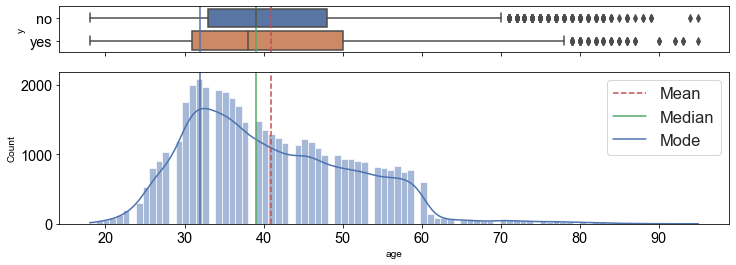

In [34]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=data_visual['age'].mean()
median=data_visual['age'].median()
mode=data_visual['age'].mode().values[0]

age = sns.boxplot(data=data_visual, x="age", y="y", ax=ax_box, order = data_visual["y"].value_counts().index)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=data_visual, x="age", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

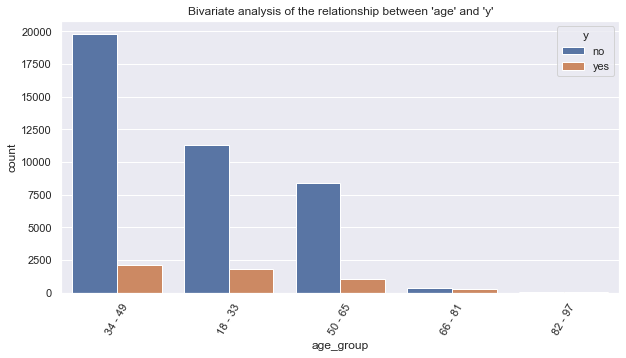

In [35]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
job = sns.countplot(x="age_group", data = data_visual, hue = "y", order = data_visual["age_group"].value_counts().index)
job.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'age' and 'y'")
plt.show()

### Job

**Bank menghubungi lebih banyak orang dengan pekerjaan 'employee'**

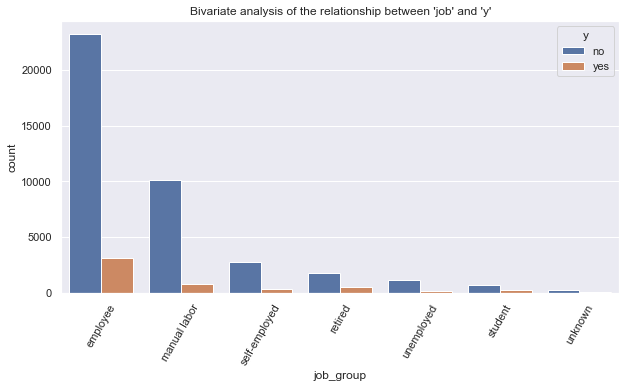

In [36]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
job = sns.countplot(x="job_group", data = data_visual, hue = "y", order = data_visual["job_group"].value_counts().index)
job.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'job' and 'y'")
plt.show()

Text(0.5, 1.0, 'Probabilitas buka tabungan deposito berdasarkan Job')

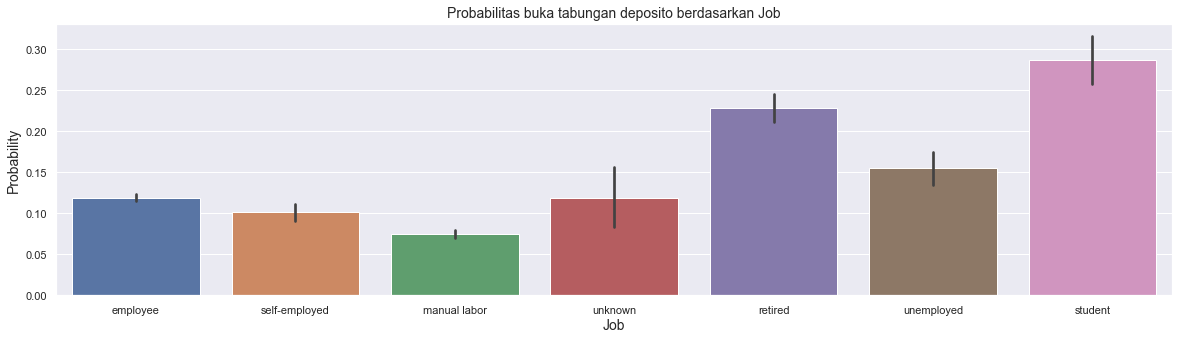

In [37]:
plt.figure( figsize = (20, 5))
sns.barplot(data = data_visual, x = 'job_group', y = 'y_num')
plt.xlabel("Job", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Probabilitas buka tabungan deposito berdasarkan Job", fontsize = 14)

### Marital Feature
**Bank lebih tertarik pada customer yang sudah menikah dan lajang daripada bercerai**

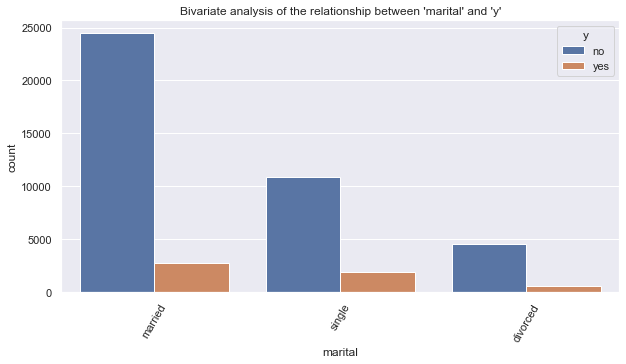

In [38]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
marital = sns.countplot(x="marital", data = data_visual, hue = "y", order = data_visual["marital"].value_counts().index)
marital.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'marital' and 'y'")
plt.show()

Text(0.5, 1.0, 'Probabilitas buka tabungan deposito berdasarkan Marital Situation')

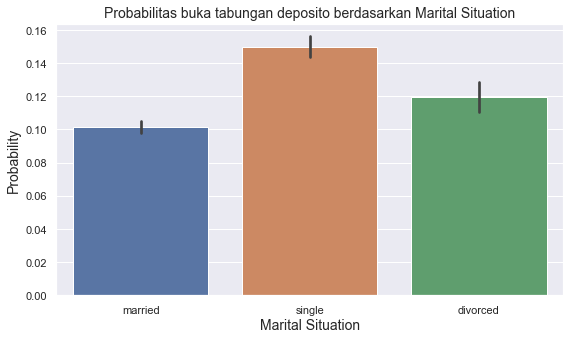

In [39]:
plt.figure( figsize = (20, 5))
plt.subplot(121)
sns.barplot(data = data_visual, x = 'marital', y = 'y_num')
plt.xlabel("Marital Situation", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Probabilitas buka tabungan deposito berdasarkan Marital Situation", fontsize = 14)

### Education
**Nasabah dengan education Secondary mendominasi pada populasi nasabah, sehingga terlihat dominan pada sebaran data. Namun secara persentase perbandingan per jenjang pendidikan, Nasabah dengan pendidikan tertiary mempunyai persentase lebih tinggi dalam pembukaan deposito**

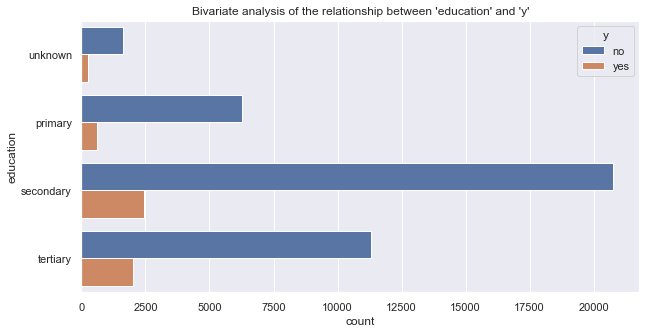

In [40]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(10, 5)})
education = sns.countplot(y="education", data = data_visual, hue = "y", order = ['unknown', 'primary', 'secondary', 'tertiary'])
plt.title("Bivariate analysis of the relationship between 'education' and 'y'")
plt.show()

Text(0.5, 1.0, 'Probabilitas buka tabungan deposito berdasarkan Education')

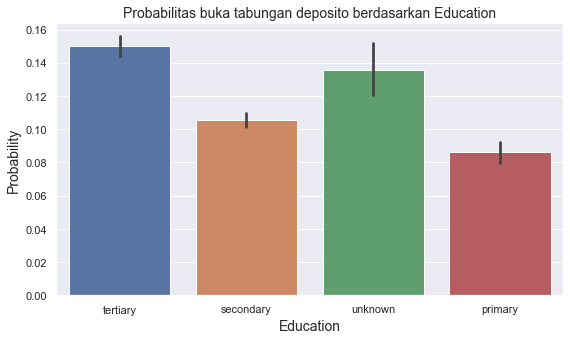

In [41]:
plt.figure( figsize = (20, 5))
plt.subplot(121)
sns.barplot(data = data_visual, x = 'education', y = 'y_num')
plt.xlabel("Education", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Probabilitas buka tabungan deposito berdasarkan Education", fontsize = 14)

### Housing

**Nasabah yang tidak memiliki kredit kepemilikan rumah lebih banyak yang membuka deposito dibandingan dengan yang memiliki kredit kepemilikan rumah**

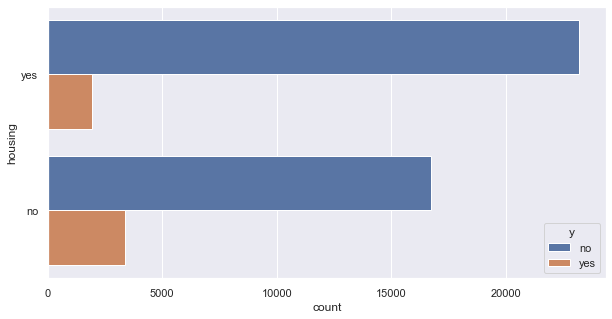

In [42]:
sns.countplot(data=data_visual, y='housing', hue='y');

### Balance

**Range besarnya saldo rata tidak mempengaruhi pembukaan rekening deposito, walaupun angka pembukaan rekening deposito didominasi oleh orang yang bersaldo di atas rata-rata.**

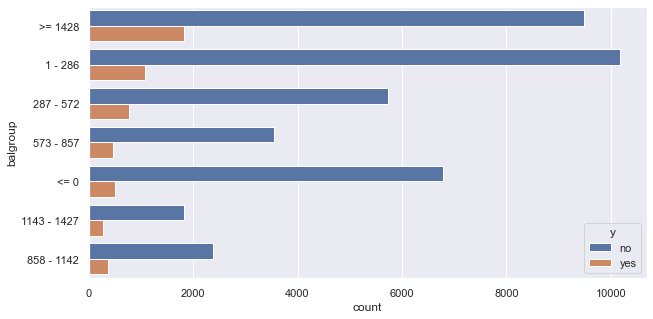

In [43]:
sns.countplot(data=data_visual, y='balgroup', hue='y');

In [44]:
df1 = data_visual[data_visual['y'] == 'yes']
df1['balgroup'].value_counts().sort_values(ascending=True)

1143 - 1427     280
858 - 1142      369
573 - 857       467
<= 0            502
287 - 572       770
1 - 286        1076
>= 1428        1825
Name: balgroup, dtype: int64

### Loan

**Dilihat dari total dan jumlah rasio, lebih banyak pelanggan yang membuka deposit jika tidak memiliki loan**

In [45]:
df_loan = data_visual.copy()
df_loan_group = df_loan.groupby(['loan', 'y'])['job'].count().reset_index()
df_loan_group.columns = ['loan', 'y', 'count']
df_loan_group['total_per_count'] = df_loan_group.groupby(['loan'])['count'].transform('sum')
df_loan_group['ratio'] = (df_loan_group['count']/df_loan_group['total_per_count'])*100
df_loan_group

,loan,y,count,total_per_count,ratio
0,no,no,33162,37967,87.344273
1,no,yes,4805,37967,12.655727
2,yes,no,6760,7244,93.318609
3,yes,yes,484,7244,6.681391


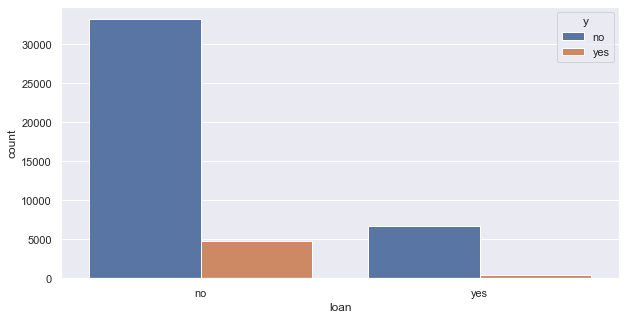

In [46]:
sns.countplot(data = data_visual, x = 'loan', hue = 'y');

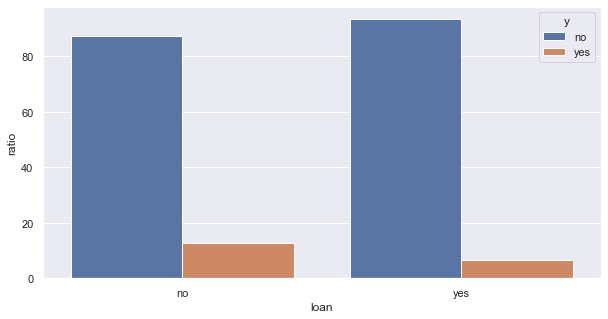

In [47]:
sns.barplot(data = df_loan_group, x = 'loan', y = 'ratio', hue = 'y');

### Default

**Tidak ada nasabah gagal bayar yang membuka deposito**

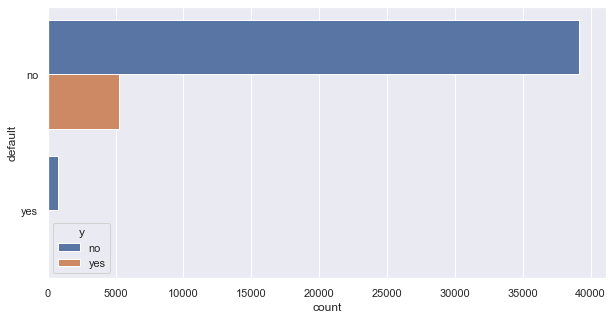

In [48]:
sns.countplot(data=data_visual, y='default', hue='y');

### Contact

**Secara rasio yang dihubungi lewat cellular maupun telephone sama saja, namun jumlahnya lebih banyak yang cellular karena mungkin lebih mudah dijangkau.**

In [49]:
df_contact = data_visual.copy()
df_contact_group = df_contact.groupby(['contact', 'y'])['job'].count().reset_index()
df_contact_group.columns = ['contact', 'y', 'count']
df_contact_group['total_per_count'] = df_contact_group.groupby(['contact'])['count'].transform('sum')
df_contact_group['ratio'] = (df_contact_group['count']/df_contact_group['total_per_count'])*100
df_contact_group

,contact,y,count,total_per_count,ratio
0,cellular,no,24916,29285,85.081100
1,cellular,yes,4369,29285,14.918900
2,telephone,no,2516,2906,86.579491
3,telephone,yes,390,2906,13.420509
4,unknown,no,12490,13020,95.929339
5,unknown,yes,530,13020,4.070661


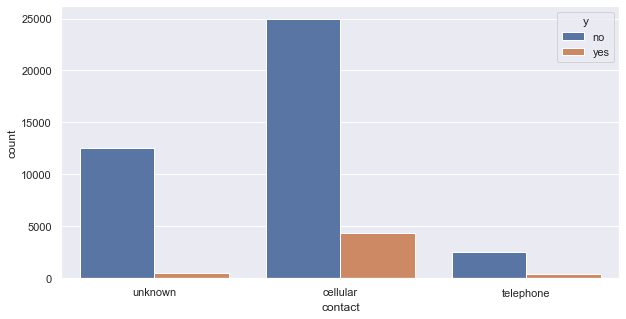

In [50]:
sns.countplot(data = data_visual, x = 'contact', hue = 'y');

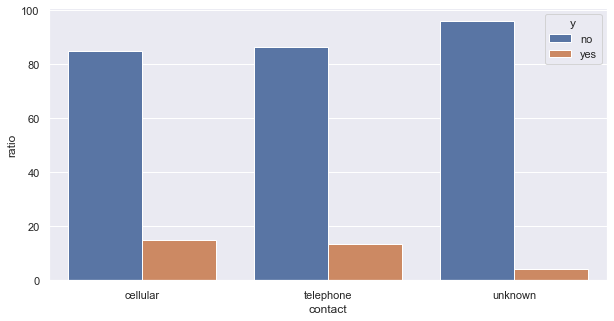

In [51]:
sns.barplot(data = df_contact_group, x = 'contact', y = 'ratio', hue = 'y');

### Month

**Secara rasio lebih banyak yang membuka deposito di bulan desember (46%) (214), maret (51%) (477), oktober (43%) (738), dan september (46%) (579). namun perusahaan lebih sering melakukan campaign di bulan mei (6%) (13766), diikuti juli (9%) (6895) dan agustus (11%) (6247) lalu juni (10%) (5341).**

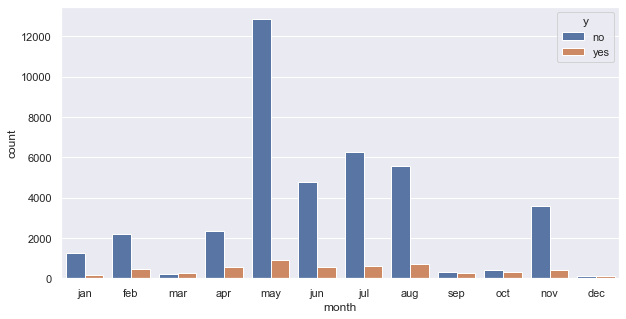

In [52]:
order_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sns.countplot(data = data_visual, x = 'month', hue = 'y', order = order_month);

In [53]:
df_month = data_visual.copy()
df_month_group = df_month.groupby(['month', 'y'])['job'].count().reset_index()
df_month_group.columns = ['month', 'y', 'count']
df_month_group['total_per_count'] = df_month_group.groupby(['month'])['count'].transform('sum')
df_month_group['ratio'] = (df_month_group['count']/df_month_group['total_per_count'])*100

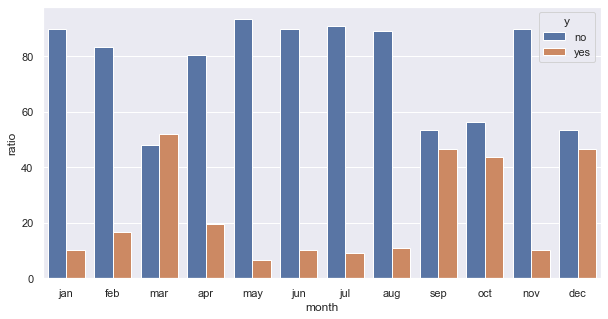

In [54]:
sns.barplot(data = df_month_group, x = 'month', y = 'ratio', hue = 'y', order = order_month);

### Day

**Day tidak mempengaruhi pembukaan deposito, entah itu awal, tengah, atau akhir bulan. Naik/turunnya nilai Day terlihat bergantung pada Month**

In [55]:
def day_month(x):
    if x <= 10:
        group = 'beginning'
    elif x <= 20:
        group = 'middle'
    else:
        group = 'end'
    return group

In [56]:
data_visual['day_month']=data_visual.apply(lambda x: day_month(x['day']),axis=1)
data_visual.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,y,cost,job_group,balgroup,age_group,y_num,day_month
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,-1,0,unknown,no,2.61,employee,>= 1428,50 - 65,0,beginning
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,-1,0,unknown,no,1.51,employee,1 - 286,34 - 49,0,beginning
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,-1,0,unknown,no,0.76,self-employed,1 - 286,18 - 33,0,beginning
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,-1,0,unknown,no,0.92,manual labor,>= 1428,34 - 49,0,beginning
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,-1,0,unknown,no,1.98,unknown,1 - 286,18 - 33,0,beginning


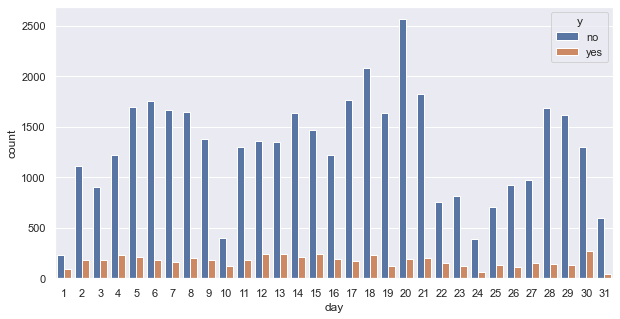

In [57]:
sns.countplot(data = data_visual, x = 'day', hue = 'y');

In [58]:
df_month_day = data_visual.copy()
df_month_day_group = df_month_day.groupby(['month', 'day_month', 'y'])['job'].count().reset_index()
df_month_day_group.columns = ['month', 'day_month', 'y', 'count']
df_month_day_group['total_per_count'] = df_month_day_group.groupby(['month', 'day_month'])['count'].transform('sum')
df_month_day_group['ratio'] = (df_month_day_group['count']/df_month_day_group['total_per_count'])*100
df_d = df_month_day_group.copy()

In [59]:
def no_month(x):
    if x == 'jan':
        no_ = 1
    elif x == 'feb':
        no_ = 2
    elif x == 'mar':
        no_ = 3
    elif x == 'apr':
        no_ = 4
    elif x == 'may':
        no_ = 5
    elif x == 'jun':
        no_ = 6
    elif x == 'jul':
        no_ = 7
    elif x == 'aug':
        no_ = 8
    elif x == 'sep':
        no_ = 9
    elif x == 'oct':
        no_ = 10
    elif x == 'nov':
        no_ = 11
    else:
        no_ = 'dec'
    return no_

def no_day(x):
    if x == 'beginning':
        no_ = 1
    elif x == 'middle':
        no_ = 2
    else:
        no_ = 3
    return no_

df_d['month_no']=df_d.apply(lambda x: no_month(x['month']),axis=1)
df_d['day_no']=df_d.apply(lambda x: no_day(x['day_month']),axis=1)

In [60]:
df_sorted = df_d.sort_values( ['month_no', 'day_no'] , ascending=True).reset_index()
df_sorted.drop('index', axis=1, inplace=True)
df_sorted['day_of_month']=df_sorted.apply(lambda x: x['month'] + ' ' + x['day_month'],axis=1)
df_sorted

,month,day_month,y,count,total_per_count,ratio,month_no,day_no,day_of_month
0,jan,beginning,no,8,11,72.727273,1,1,jan beginning
1,jan,beginning,yes,3,11,27.272727,1,1,jan beginning
2,jan,middle,no,49,104,47.115385,1,2,jan middle
3,jan,middle,yes,55,104,52.884615,1,2,jan middle
4,jan,end,no,1204,1288,93.478261,1,3,jan end
...,...,...,...,...,...,...,...,...,...
67,dec,beginning,yes,46,99,46.464646,dec,1,dec beginning
68,dec,middle,no,28,50,56.000000,dec,2,dec middle
69,dec,middle,yes,22,50,44.000000,dec,2,dec middle
70,dec,end,no,33,65,50.769231,dec,3,dec end


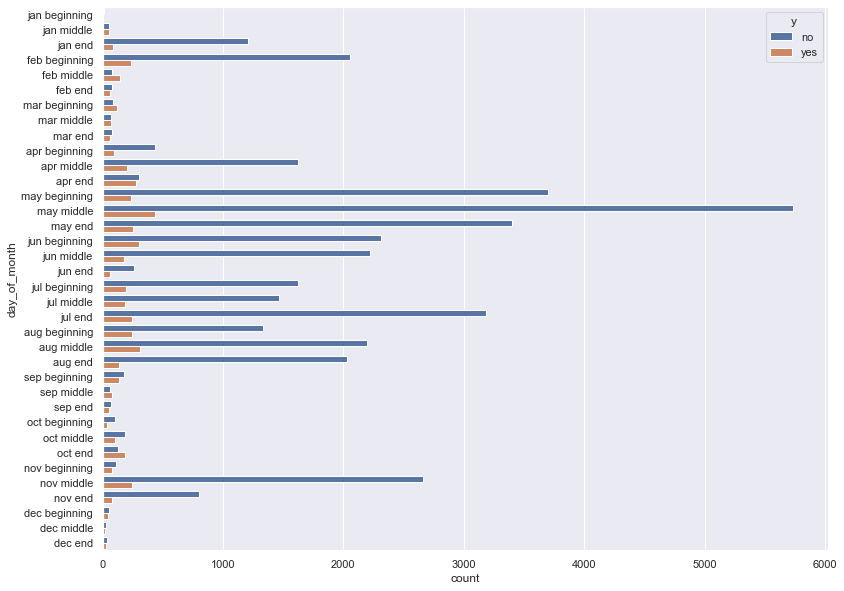

In [61]:
plt.figure(figsize = (13, 10))
sns.barplot(data = df_sorted, x= 'count', y = 'day_of_month', hue = 'y');

### Campaign

Dari data kolom **campaign** ditemukan bahwa mayoritas customer yang akhirnya membuka rekening deposito hanya cukup dihubungi 2-3 kali. <br> <br>
Sehingga dari pola yang ditemukan ini, saran yang dapat diberikan kepada tim marketing adalah membatasi jumlah kontak yang dilakukan ke masing-masing maksimal sampai 3 kali saja, karena bisa meningkatkan dari sisi efisiensi ataupun resource yang tersedia dapat dialihkan untuk melakukan approach ke customer lainnya.

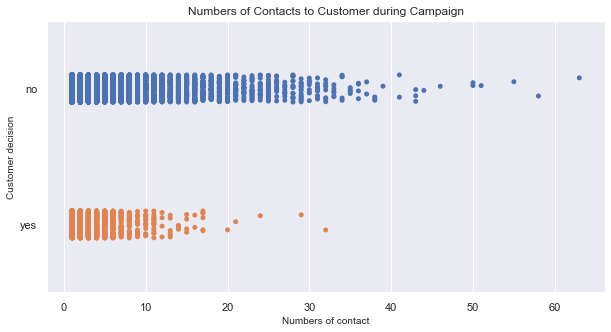

In [62]:
sns.stripplot(data=data_visual, x='campaign', y='y')

plt.title('Numbers of Contacts to Customer during Campaign')
plt.xlabel('Numbers of contact',fontsize=10)
plt.ylabel('Customer decision',fontsize=10);

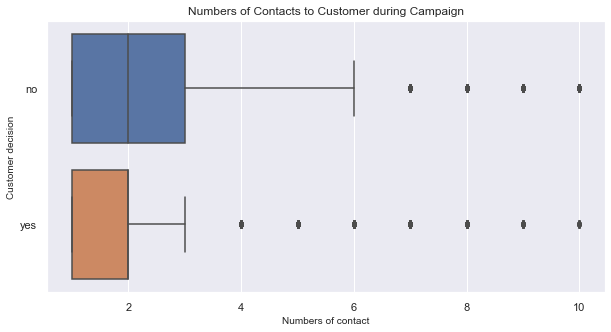

In [63]:
df_campaign = data_visual.loc[df['campaign']<=10] ## Untuk lebih lihat detil sebaran keputusan customer, karena mayoritas yang membuka dihubungi <10 kali

sns.boxplot(data=df_campaign, x='campaign', y='y')
plt.title('Numbers of Contacts to Customer during Campaign')
plt.xlabel('Numbers of contact',fontsize=10)
plt.ylabel('Customer decision',fontsize=10);

### Pdays

Dari data kolom **pdays** ditemukan bahwa mayoritas customer yang akhirnya membuka rekening deposito pernah dihubungi dalam jangka waktu 200 hari terakhir. <br> <br> 
Melihat pola ini, saran yang dapat diberikan kepada tim marketing/terkait adalah memastikan untuk melakukan follow up secara berkala, khususnya customer-customer potensial. <br> <br>
Dengan follow up yang dilakukan secara berkala ini, diharapkan dapat customer engagement dapat meningkat dan berdampak pada tingkat penjualan produk-produk Bank Portugal secara menyeluruh.

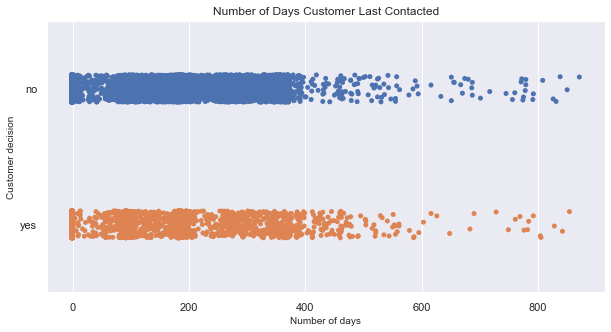

In [64]:
sns.stripplot(data=data_visual, x='pdays', y='y')

plt.title('Number of Days Customer Last Contacted')
plt.xlabel('Number of days',fontsize=10)
plt.ylabel('Customer decision',fontsize=10);

In [65]:
pdays_clean = data_visual.loc[df['pdays']!=-1] ## Exclude orang-orang yang belum pernah dikontak sebelumnya
pdays_yes = pdays_clean.loc[pdays_clean['y']=='yes']
pdays_no = pdays_clean.loc[pdays_clean['y']=='no']

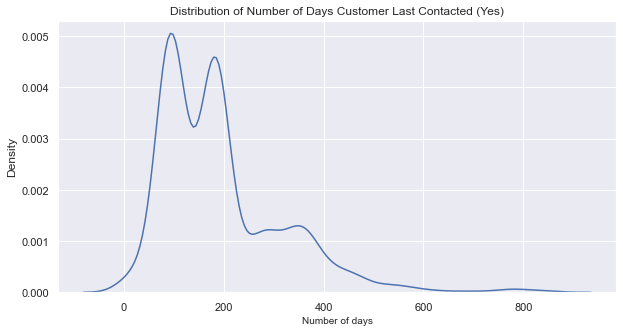

In [66]:
sns.kdeplot(data=pdays_yes, x='pdays')

plt.title('Distribution of Number of Days Customer Last Contacted (Yes)')
plt.xlabel('Number of days',fontsize=10);

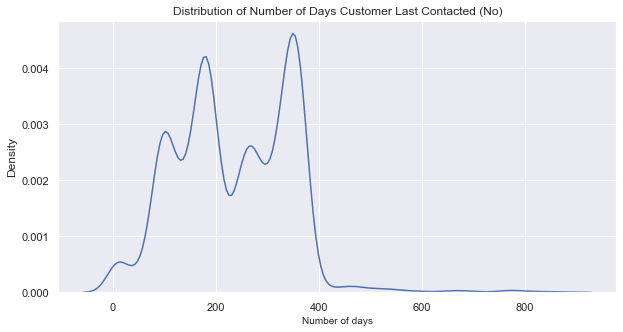

In [67]:
sns.kdeplot(data=pdays_no, x='pdays')

plt.title('Distribution of Number of Days Customer Last Contacted (No)')
plt.xlabel('Number of days',fontsize=10);

### Previous

Dari data kolom **previous** ditemukan bahwa mayoritas customer yang membuka tabungan deposito pernah dihubungi sebanyak 1-2 kali sebelum campaign berlangsung. <br> <br> 
Hal ini selaras dengan temuan pada kolom **pdays** dimana mayoritas customer yang membuka tabungan deposito pernah dihubungi dalam jangka waktu 200 hari terakhir. <br> <br>
Sehingga, saran yang diberikan ke tim marketing/terkait sebelumnya semakin diperkuat dengan temuan pada data kolom **previous**.

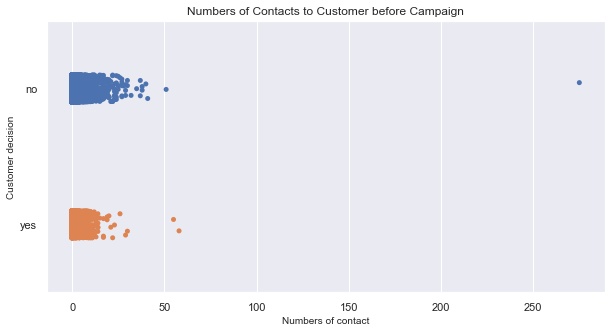

In [68]:
sns.stripplot(data=data_visual, x='previous', y='y')

plt.title('Numbers of Contacts to Customer before Campaign')
plt.xlabel('Numbers of contact',fontsize=10)
plt.ylabel('Customer decision',fontsize=10);

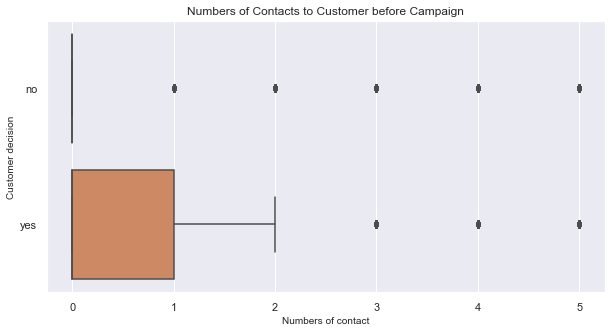

In [69]:
previous_vis = df.loc[df['previous']<=5] ##Untuk melihat lebih rinci sebaran customer pada kategori yes

sns.boxplot(data=previous_vis, x='previous', y='y')

plt.title('Numbers of Contacts to Customer before Campaign')
plt.xlabel('Numbers of contact',fontsize=10)
plt.ylabel('Customer decision',fontsize=10);

### Poutcome

Hasil dari campaign marketing yang telah dilakukan sebelumnya sangat berpengaruh terhadap jumlah pembukaan rekening deposito. <br> <br>
Hal ini dapat dilihat dari count pada kategori **success** dimana lebih banyak customer yang membuka rekening deposito, dibandingkan yang tidak membuka rekening deposito. <br> <br>

Sehingga, tim marketing dapat memprioritaskan untuk melakukan approach kepada nasabah yang sudah pernah berpartisipasi pada campaign sebelumnya.


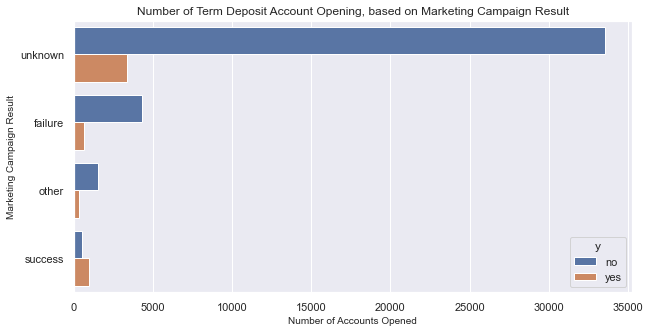

In [70]:
sns.countplot(data=df, y='poutcome', hue='y')

plt.title('Number of Term Deposit Account Opening, based on Marketing Campaign Result');
plt.xlabel('Number of Accounts Opened', fontsize=10)
plt.ylabel('Marketing Campaign Result',fontsize=10);

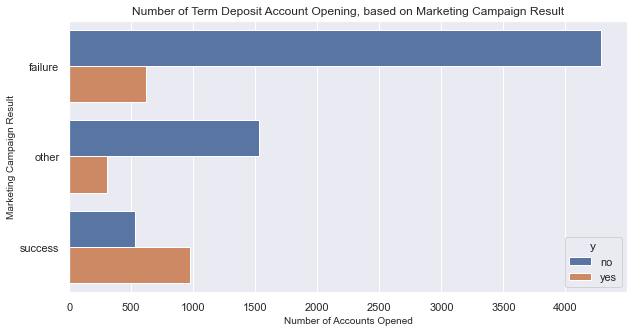

In [71]:
pout_vis = df.loc[df['poutcome']!='unknown'] ##Exclude untuk yang kategori unknown, karena terlalu dominan pada data
sns.countplot(data=pout_vis, y='poutcome', hue='y')

plt.title('Number of Term Deposit Account Opening, based on Marketing Campaign Result');
plt.xlabel('Number of Accounts Opened', fontsize=10)
plt.ylabel('Marketing Campaign Result',fontsize=10);

### Correlation Heatmap

Text(0.5, 1.0, 'Features Correlation')

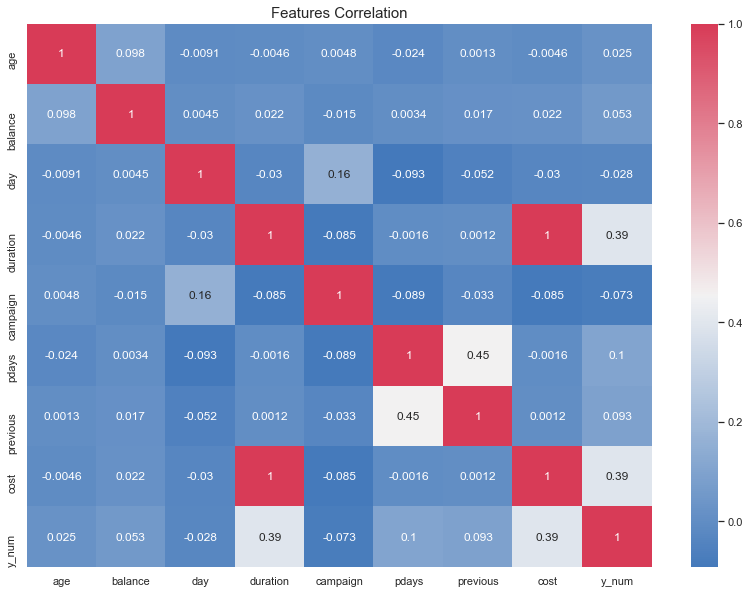

In [72]:
color = sns.diverging_palette(250, 6, as_cmap = True)

plt.figure(figsize = (14, 10))
sns.heatmap(data_visual.corr(), cmap = color, annot = True)
plt.title("Features Correlation", fontsize = 15)

## Pemilihan Feature

**Categorical features: ["job_group","marital","education","default","housing", "loan", "contact", "poutcome", "y"]**<br>
**Numerical features: ["age", "balance", "duration/cost", "campaign"]**

**a. Replace "unknown" variable di ["job", "education", "contact"].**<br>
**b. Drop features: ["month", "previous", "day", "pdays","duration/cost"]**

In [73]:
df_model.columns

Index(['age', 'job', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'cost', 'balgroup',
       'age_group', 'job_group_employee', 'job_group_manual labor',
       'job_group_retired', 'job_group_self-employed', 'job_group_student',
       'job_group_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [74]:
y = df_model['y'].values
X = df_model.drop(labels = ['job', 'day', 'month', 'y', 'pdays', 'previous', 'cost', 'balgroup', 'age_group'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (45211, 26) and that of y is (45211,)


## Class Imbalance

In [75]:
X_sm, y_sm = over_sampling.SMOTE(0.5).fit_resample(X, y)
print("Shape of X is {} and that of y is {}".format(X_sm.shape, y_sm.shape))

Shape of X is (59883, 26) and that of y is (59883,)


# Modeling

In [76]:
def eval_classification(model, xtrain, ytrain, xtest, ytest):
    ypred = model.predict(xtest)
    ypred = (ypred > 0.5).astype(int)
    y_train = model.predict(xtrain)
    y_train = (y_train > 0.5).astype(int)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, ypred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, ypred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, ypred))
    print("AUC (Test Set - Proba) : %.2f" % roc_auc_score(ytest, ypred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, ypred))
    print("F1-Score (Train Set): %.2f" % f1_score(ytrain, y_train))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

## Split Train-Test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 42)

## KNN

In [78]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
eval_classification(knn,X_train,y_train,X_test,y_test)

Accuracy (Test Set): 0.81
Precision (Test Set): 0.69
Recall (Test Set): 0.78
AUC (Test Set - Proba) : 0.81
F1-Score (Test Set): 0.74
F1-Score (Train Set): 0.83


## AdaBoost

In [79]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)
eval_classification(ab,X_train,y_train,X_test,y_test)

Accuracy (Test Set): 0.91
Precision (Test Set): 0.90
Recall (Test Set): 0.82
AUC (Test Set - Proba) : 0.89
F1-Score (Test Set): 0.86
F1-Score (Train Set): 0.86


## XGBoost

In [80]:
xg = XGBClassifier(random_state=42)
xg.fit(X_train,y_train)
eval_classification(xg,X_train,y_train,X_test,y_test)

[21:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.92
Precision (Test Set): 0.90
Recall (Test Set): 0.85
AUC (Test Set - Proba) : 0.90
F1-Score (Test Set): 0.88
F1-Score (Train Set): 0.92


## Decission Tree

In [81]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
eval_classification(model, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.81
Recall (Test Set): 0.83
AUC (Test Set - Proba) : 0.87
F1-Score (Test Set): 0.82
F1-Score (Train Set): 1.00


## Random Forest

In [82]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
eval_classification(rf, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.90
Recall (Test Set): 0.85
AUC (Test Set - Proba) : 0.90
F1-Score (Test Set): 0.88
F1-Score (Train Set): 1.00


## Logistic Regression Statsmodel

In [83]:
X_train_stat = sm.add_constant(X_train)
X_test_stat = sm.add_constant(X_test)

### Fit Reguralized

In [84]:
logit_model=sm.Logit(y_train,X_train_stat)
result=logit_model.fit_regularized(random_state = 42)
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19811122509105195
            Iterations: 201
            Function evaluations: 217
            Gradient evaluations: 201
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41918
Model:                          Logit   Df Residuals:                    41891
Method:                           MLE   Df Model:                           26
Date:                Fri, 14 Jan 2022   Pseudo R-squ.:                  0.6891
Time:                        21:20:27   Log-Likelihood:                -8304.4
converged:                       True   LL-Null:                       -26714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [85]:
eval_classification(result, X_train_stat, y_train, X_test_stat, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.93
Recall (Test Set): 0.82
AUC (Test Set - Proba) : 0.89
F1-Score (Test Set): 0.87
F1-Score (Train Set): 0.87


In [86]:
logit_model=sm.Logit(y_train,X_train_stat)
result=logit_model.fit_regularized(random_state = 42,alpha=0.0001,L1_wt=0)
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19811409556942464
            Iterations: 195
            Function evaluations: 210
            Gradient evaluations: 195
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41918
Model:                          Logit   Df Residuals:                    41891
Method:                           MLE   Df Model:                           26
Date:                Fri, 14 Jan 2022   Pseudo R-squ.:                  0.6891
Time:                        21:20:29   Log-Likelihood:                -8304.4
converged:                       True   LL-Null:                       -26714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

C:\Users\Dell\anaconda new\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 26 out of 27 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\Dell\anaconda new\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [87]:
eval_classification(result, X_train_stat, y_train, X_test_stat, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.93
Recall (Test Set): 0.82
AUC (Test Set - Proba) : 0.89
F1-Score (Test Set): 0.87
F1-Score (Train Set): 0.87
